In [627]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer # tfidf
from sklearn.metrics.pairwise import linear_kernel # 코사인 유사도
from konlpy.tag import Okt # 토큰화
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from soynlp.normalizer import emoticon_normalize, repeat_normalize
import soynlp.tokenizer
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import optimizers
import keras.utils
import sklearn.metrics as metrics
from konlpy.tag import Komoran
from pykospacing import spacing # 띄어쓰기
from hanspell import spell_checker # 맞춤법
import pickle
from tqdm import trange, notebook # show progress-bar

In [10]:
data = pd.read_csv("data/train.hate.csv")
data

,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,hate
...,...,...
7891,힘내세요~ 응원합니다!!,none
7892,힘내세요~~삼가 고인의 명복을 빕니다..,none
7893,힘내세용 ^^ 항상 응원합니닷 ^^ !,none
7894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,none


In [11]:
data2 = pd.read_csv("data/dev.hate.csv")
data2

,comments,label
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,none
1,지현우 나쁜놈,offensive
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,hate
3,설마 ㅈ 현정 작가 아니지??,hate
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,offensive
...,...,...
466,지현우 범죄 저지르지 않았나요?,offensive
467,여자인생 망칠 일 있나 ㅋㅋ,hate
468,근데 전라도에서 사고가 났는데 굳이 서울까지 와서 병원에 가느 이유는?,offensive
469,"할매젖x, 뱃살x, 몸매 s라인, 유륜은 적당해야됨(너무크거나 너무 작아도 x), ...",hate


In [15]:
data3 = pd.read_csv("unlabeled_cut.csv")
data3

,comments,label
0,지드래곤은 난봉꾼이란...댓글도 달렸네 ㅋㅋ 이주연 학창시절 사진 보고 와라. 요즘...,none
1,이주연은 알겠는데 지디는 뭐하는 듣보잡여,hate
2,부럽네요. 나도 불과 한달전까진 허니문베이비를 꿈꿨는데 이제 다 부질없네요. 당연히...,offensive
3,이주연을 모르는 애들이 많네. 해체된 애프터스쿨 멤버로 당시는 주연이 예명. 인기나...,none
4,겨론했으면,none
...,...,...
1006,친일 재산 환수하고 이런 얘기 하세요. 출연료 받아가며 일하는데 뭘 칭찬하는 건지,hate
1007,하늘에서 흥선대원군이 노하고있겠군,hate
1008,강동원이 이한열역을? 너무 배역과 나이차이 나는거 아닌가요? 실제본 분은 어땟나요?...,none
1009,댓글들 ㅋㅋㅋ 친일파 손자라고 깔 땐 언제고 ㅋㅋㅋ 미친,offensive


In [793]:
data = pd.concat([data,data2,data3])
data.to_csv("data.csv")

In [17]:
okt=Okt()

In [ ]:
# df = pd.read_csv("stop_words.csv",header=None,encoding='cp949')
# stopwords = df[1].tolist()

In [29]:
# df = pd.read_csv("data/korean_stopwords.txt",header=None)
# stopwords = df[0].tolist()

In [18]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [796]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords = set(stopwords)

In [284]:
# sen = "대체왜않돼는지설명을해바"
# sen = spacing(sen)
# spelled_sent = spell_checker.check(sen)
# checked_sent = spelled_sent.checked
# checked_sent

'대체 왜 안되는지 설명을 해봐'

In [675]:
# okt 띄어쓰기, 맞춤법 X
token=[]
for i in notebook.tqdm(data['comments']):
    hangul=re.compile('[^ ㄱ-ㅎㅏ-ㅣ가-힣]+')
    i = hangul.sub('', i) 
    i=repeat_normalize(i,num_repeats=2) # 반복되는 문자 정제
    temp = okt.morphs(i,stem=True,norm=True)
    temp= [word for word in temp if not word in stopwords]
    token.append(temp)


In [748]:
# okt 띄어쓰기, 맞춤법 포함
token=[]
for i in notebook.tqdm(data['comments']):
    hangul=re.compile('[^ ㄱ-ㅎㅏ-ㅣ가-힣]+')
    i = hangul.sub('', i) 
    i=repeat_normalize(i,num_repeats=3) # 반복되는 문자 정제
    i = spacing(i) # 띄어쓰기
    i = spell_checker.check(i)
    i = i.checked # 맞춤법
    temp = okt.morphs(i,stem=True,norm=True)
    temp= [word for word in temp if not word in stopwords]
    token.append(temp)


In [873]:
with open('token.p', 'rb') as file: # mecab tokenizer
    token = pickle.load(file)
    print(token)


[['현재', '호텔', '주인', '심정', '아', '난', '마른', '하늘', '날벼락', '맞', '호텔', '망하', '생겼', '는데', '누군', '계속', '추모', '받'], ['한국', '적', '미인', '대표', '적', '분', '너무나', '곱', '아름다운', '모습', '그', '모습', '뒤', '슬픔', '미처', '알', '못했', '네요', 'ㅠ'], ['못', '된', '넘', '남', '고통', '즐겼', '던', '넘', '이젠', '마땅', '처벌', '받', '아야지', '그래야', '공정', '사회', '지심', '대', '로', '거두', '거라'], ['화', '어설펐', '는데', '화', '지나', '서', '부터', '갈수록', '너무', '재밌', '던데'], ['사람', '얼굴', '손톱', '긁', '것', '인격', '살해', '동영상', '몰카', '냐', '메', '걸리', '안들', '생각', '없', '노'], ['진짜', '이승기', '랑', '비교', '된다'], ['년', '안', '남녀', '간', '성', '전쟁', '번', '크', '치룬', '후', '일부다처제', '여성', '정치', '참여', '금지', '여성', '투표', '권', '삭제', '세계', '공통', '문화', '로', '자리', '잡', '암탉', '너무', '울', '어', '댐'], ['년', '뒤', '윤서인', '분명히', '재', '평가', '될', '것', '말', '하나하나', '틀린', '없'], ['년', '재미', '느끼', '프로', '였', '는데', '왜', '니', '때문', '폐지', '해야', '냐'], ['년차', '방탄', '팬', '인데', '우리', '방탄', '처럼', '성공', '못', '겠', '지만', '일단', '방탄', '부하', '싶', '다는', '거', '니', '름기억은해둠ㅇㅇ'], ['살', '차이', '넘', '텐데', '부부', '라고', '무슨',

In [749]:
# # Komoran
# komoran = Komoran()
# token=[]
# for i in data['comments']:
#     hangul=re.compile('[^ ㄱ-ㅣ가-힣]+')
#     i = hangul.sub('', i) 
#     i=repeat_normalize(i,num_repeats=3) # 반복되는 문자 정제
#     temp = komoran.morphs(i)
#     temp= [word for word in temp if not word in stopwords]
#     token.append(temp)

In [750]:
# # Mecab
# mecab = Mecab(dicpath='C;\mecab\mecab-ko-dic')
# token=[]
# for i in data['comments']:
#     hangul=re.compile('[^ ㄱ-ㅣ가-힣]+')
#     i = hangul.sub('', i) 
#     i=repeat_normalize(i,num_repeats=3) # 반복되는 문자 정제
#     temp = mecab.morphs(i)
#     temp= [word for word in temp if not word in stopwords]
#     token.append(temp)

In [874]:
token = pd.Series(token)

In [875]:
data['token'] = token

In [876]:
data['label'].value_counts()

none         4432
offensive    3765
hate         2663
Name: label, dtype: int64

In [877]:
df = data[['label','token']]

In [878]:
df.to_csv("token.csv")

In [879]:
train, test = train_test_split(df, test_size=0.3)

In [880]:
print(train.shape)
print(test.shape)

(7602, 2)
(3258, 2)


In [881]:
xTrain = train['token'].tolist()
xTest = test['token'].tolist()

In [882]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xTrain)

In [883]:
print(tokenizer.word_index)

{'거': 1, '안': 2, '있': 3, '나': 4, '보': 5, 'ㅋㅋ': 6, '아': 7, '없': 8, '는데': 9, '좋': 10, '냐': 11, '어': 12, '같': 13, '여자': 14, '겠': 15, '로': 16, '사람': 17, '아니': 18, '왜': 19, '니': 20, '것': 21, '했': 22, '기': 23, '에서': 24, '해': 25, '말': 26, '주': 27, '진짜': 28, '너무': 29, '었': 30, 'ㅋㅋㅋ': 31, '라': 32, '할': 33, '야': 34, '그': 35, '살': 36, '뭐': 37, '못': 38, '애': 39, '많': 40, '적': 41, '남자': 42, '세요': 43, '그냥': 44, '더': 45, '일': 46, '년': 47, '네요': 48, '때': 49, '건': 50, '결혼': 51, '않': 52, '알': 53, '인데': 54, '서': 55, '시': 56, '지만': 57, '으면': 58, '씨': 59, '나오': 60, 'ㅋ': 61, '기사': 62, '라고': 63, '까지': 64, '았': 65, '수': 66, '싶': 67, '연기': 68, '내': 69, '랑': 70, '먹': 71, '받': 72, '돈': 73, '개': 74, '대': 75, '던': 76, '드라마': 77, '님': 78, '다고': 79, '해서': 80, '해라': 81, '이제': 82, '얼굴': 83, '생각': 84, '남': 85, '넘': 86, '다는': 87, '근데': 88, '연예인': 89, '하나': 90, '마': 91, '저': 92, '걸': 93, '댓글': 94, 'ㄷ': 95, '한테': 96, '참': 97, '싫': 98, '어요': 99, '플': 100, '사': 101, '면서': 102, '데': 103, '이런': 104, '중': 105, '많이': 106, '길': 

In [884]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 11238
등장 빈도가 1번 이하인 희귀 단어의 수: 4966
단어 집합에서 희귀 단어의 비율: 44.189357536928284
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.843885642941446


In [885]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6274


In [886]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(xTrain)
xTrain = tokenizer.texts_to_sequences(xTrain)
xTest = tokenizer.texts_to_sequences(xTest)

In [887]:
xTrain = np.array(xTrain)

In [888]:
xTest = np.array(xTest)

In [889]:
xTrain.shape

(7602,)

In [890]:
xTest.shape

(3258,)

In [891]:
yTrain = np.array(train['label'])
yTest = np.array(test['label'])

In [892]:
yTrain.shape

(7602,)

In [893]:
yTest.shape

(3258,)

리뷰의 최대 길이 : 50
리뷰의 평균 길이 : 13.486056300973429


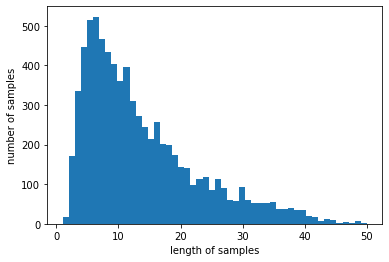

In [894]:
print('리뷰의 최대 길이 :',max(len(l) for l in xTrain))
print('리뷰의 평균 길이 :',sum(map(len, xTrain))/len(xTrain))
plt.hist([len(s) for s in xTrain], bins=max(len(l) for l in xTrain))
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [895]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [896]:
max_len = 45
below_threshold_len(max_len, xTrain)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 99.73691133912128


In [897]:
xTrain = pad_sequences(xTrain, maxlen = max_len)
xTest = pad_sequences(xTest, maxlen = max_len)

In [898]:
print(len(xTrain))
print(len(yTrain))

7602
7602


In [899]:
xTrain

array([[   0,    0,    0, ...,    1, 1899, 1044],
       [   0,    0,    0, ...,  940,  283,   26],
       [   0,    0,    0, ...,  269,   55,    7],
       ...,
       [   0,    0,    0, ...,  536,   31,    7],
       [   0,    0,    0, ..., 1059,    3,    1],
       [   0,    0,    0, ..., 4028,   60, 1084]])

In [900]:
def vs(seq):
    res = np.zeros((len(seq),len(yTrain))) 
    for i,sequence in enumerate(seq):
        res[i, sequence] = 1
                 
    return res

xTrain = vs(xTrain)
xTest = vs(xTest)

In [901]:
# for i in range(len(yTrain)):
#     if yTrain[i] == 'offensive':
#         yTrain[i] = float(1)
      
#     elif yTrain[i] == 'hate':
#         yTrain[i] = float(2)
  
#     elif yTrain[i] == 'none':
#         yTrain[i] = float(0)
      
#     else:
#         pass
  

In [902]:
# binary classification
for i in range(len(yTrain)):
    if yTrain[i] == 'none':
        yTrain[i] = float(0)
      
    else:
        yTrain[i] = float(1)

In [903]:
# for i in range(len(yTest)):
#     if yTest[i] == 'hate':
#         yTest[i] = float(2)
      
#     elif yTest[i] == 'offensive':
#         yTest[i] = float(1)
      
#     elif yTest[i] == 'none':
#         yTest[i] = float(0)
      
#     else:
#         pass


In [904]:
# binary classification
for i in range(len(yTest)):
    if yTest[i] == 'none':
        yTest[i] = float(0)
      
    else:
        yTest[i] = float(1)


In [905]:
yTrain = yTrain.astype(float)
yTest = yTest.astype(float)
print(yTrain)
print(yTest)

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 0. 1. 0.]


In [851]:
# yTrain = keras.utils.to_categorical(yTrain, 3)
# yTest = keras.utils.to_categorical(yTest, 3)

In [916]:
# 변수 저장
with open('mecab,stop_2.p', 'wb') as file:    
    pickle.dump(xTrain, file)
    pickle.dump(xTest, file)
    pickle.dump(yTrain, file)
    pickle.dump(yTest, file)

In [792]:
# # 변수 불러오기
# with open('check_X,repeat_2.p', 'rb') as file:    
#     xTrain = pickle.load(file)
#     xTest = pickle.load(file)
#     yTrain = pickle.load(file)
#     yTest = pickle.load(file)
#     print(xTrain)
#     print(xTest)
#     print(yTrain)
#     print(yTest)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]]
[1. 1. 0. ... 1. 1. 1.]
[1. 0. 1. ... 0. 0. 0.]


In [786]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [787]:
# LSTM
# model = Sequential()
# model.add(Embedding(len(xTrain),max_len))
# model.add(LSTM(16))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation = 'sigmoid'))
# model.summary()

In [788]:
# GRU
model = Sequential()
model.add(Embedding(len(xTrain),max_len))
model.add(GRU(16))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 40)          262560    
_________________________________________________________________
gru_5 (GRU)                  (None, 16)                2784      
_________________________________________________________________
dense_118 (Dense)            (None, 128)               2176      
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 129       
Total params: 267,649
Trainable params: 267,649
Non-trainable params: 0
_________________________________________________________________


In [671]:
# model = Sequential()
# model.add(Dense(512,input_dim = len(xTrain),activation='relu'))
# model.add(Dense(256,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(3, activation = 'softmax'))
# model.summary()

In [906]:
model = Sequential()
model.add(Dense(512,input_dim = len(xTrain),activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 512)               3892736   
_________________________________________________________________
dense_129 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_130 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 65        
Total params: 4,040,577
Trainable params: 4,040,577
Non-trainable params: 0
_________________________________________________________________


In [907]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
adam = optimizers.Adam(lr = 0.00001)
sgd = optimizers.SGD(lr=0.1,decay=1e-6,momentum=0.9, nesterov = True)

In [908]:
model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer = adam)
history = model.fit(xTrain, yTrain, epochs=10000, callbacks=[es, mc], batch_size=100, validation_split=0.2)

Epoch 1/10000
60/61 [============================>.] - ETA: 0s - loss: 0.6954 - acc: 0.4512
Epoch 00001: val_acc improved from -inf to 0.51019, saving model to best_model.h5
61/61 [==============================] - 2s 31ms/step - loss: 0.6953 - acc: 0.4537 - val_loss: 0.6927 - val_acc: 0.5102
Epoch 2/10000
60/61 [============================>.] - ETA: 0s - loss: 0.6885 - acc: 0.5977
Epoch 00002: val_acc improved from 0.51019 to 0.58383, saving model to best_model.h5
61/61 [==============================] - 2s 27ms/step - loss: 0.6884 - acc: 0.5981 - val_loss: 0.6882 - val_acc: 0.5838
Epoch 3/10000
59/61 [============================>.] - ETA: 0s - loss: 0.6823 - acc: 0.5971
Epoch 00003: val_acc did not improve from 0.58383
61/61 [==============================] - 2s 28ms/step - loss: 0.6824 - acc: 0.5956 - val_loss: 0.6840 - val_acc: 0.5819
Epoch 4/10000
60/61 [============================>.] - ETA: 0s - loss: 0.6766 - acc: 0.5923
Epoch 00004: val_acc did not improve from 0.58383
61/61

59/61 [============================>.] - ETA: 0s - loss: 0.3630 - acc: 0.8671
Epoch 00030: val_acc did not improve from 0.69231
61/61 [==============================] - 2s 26ms/step - loss: 0.3634 - acc: 0.8665 - val_loss: 0.6032 - val_acc: 0.6903
Epoch 31/10000
60/61 [============================>.] - ETA: 0s - loss: 0.3509 - acc: 0.8705
Epoch 00031: val_acc did not improve from 0.69231
61/61 [==============================] - 2s 26ms/step - loss: 0.3501 - acc: 0.8716 - val_loss: 0.6059 - val_acc: 0.6877
Epoch 32/10000
59/61 [============================>.] - ETA: 0s - loss: 0.3375 - acc: 0.8783
Epoch 00032: val_acc did not improve from 0.69231
61/61 [==============================] - 2s 25ms/step - loss: 0.3374 - acc: 0.8783 - val_loss: 0.6103 - val_acc: 0.6897
Epoch 33/10000
59/61 [============================>.] - ETA: 0s - loss: 0.3258 - acc: 0.8824
Epoch 00033: val_acc did not improve from 0.69231
61/61 [==============================] - 2s 25ms/step - loss: 0.3253 - acc: 0.8829 

In [909]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(xTest, yTest)[1]))

102/102 [==============================] - 0s 4ms/step - loss: 0.5810 - acc: 0.7001

 테스트 정확도: 0.7001


In [910]:
pred = loaded_model.predict(xTest)
pred

array([[0.6946768 ],
       [0.12130001],
       [0.85653096],
       ...,
       [0.48181695],
       [0.8781103 ],
       [0.58496183]], dtype=float32)

In [911]:
yTest_decode = []
for i in range(len(yTest)):
    if yTest[i] >= 0.5:
        yTest_decode.append(1)
    else:
        yTest_decode.append(0)
# print(yTest_decode)

In [912]:
pred_decode = []
for i in range(len(pred)):
    if pred[i] >= 0.5:
        pred_decode.append(1)
    else:
        pred_decode.append(0)
# print(pred_decode)

In [913]:
# yTest_decode = []
# for i in range(len(pred)):
#     val = yTest[i].argmax()
#     yTest_decode.append(val)
# len(yTest_decode)

In [914]:
# pred_decode = []
# for i in range(len(yTest)):
#     val = pred[i].argmax()
#     pred_decode.append(val)
# len(pred_decode)

In [915]:
print('f1 : ',metrics.f1_score(yTest_decode, pred_decode, average='macro'))
print('recall : ', metrics.recall_score(yTest_decode,pred_decode,average='macro'))
print('precision : ',metrics.precision_score(yTest_decode,pred_decode,average='macro'))
print('accuracy', metrics.accuracy_score(yTest_decode, pred_decode,))

f1 :  0.681238048552357
recall :  0.6783900696984739
precision :  0.6882598213253629
accuracy 0.7001227747084101


In [872]:
# okt
# f1: 0.5471
# acc: 0.5753

In [94]:
# komoran
# f1: 0.5223
# acc: 0.5547

In [ ]:
## okt + LSTM(16) 
# f1:  0.5307
# accuracy: 0.5618

In [ ]:
# 이진분류 
# tokenizer: okt 
# algorithm: dense
# 맞춤법 띄어쓰기 X
# f1 :  0.6807567709756073
# recall :  0.6778271090821866
# precision :  0.6950549137298008
# accuracy 0.701137171286425

In [ ]:
# 이진분류 
# tokenizer: okt 
# algorithm: dense
# 맞춤법 띄어쓰기 O
# f1 :  0.6658401225447004
# recall :  0.663960960750946
# precision :  0.6845019945169002
# accuracy 0.6886993603411514

In [ ]:
# 이진분류 
# tokenizer: okt 
# algorithm: LSTM + dense
# 맞춤법 띄어쓰기 O


In [ ]:
# 이진분류 
# tokenizer: okt 
# algorithm: LSTM + dense
# 맞춤법 띄어쓰기 X
